In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


## CNN and Transformer Classes

In [5]:
'''
Model Classes
'''
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_channels=64):
        super(CNNFeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First Conv Layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),  # Final Conv Layer
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.cnn(x)

    
class TransformerSegmentationModel(nn.Module):
    def __init__(self, cnn_extractor= CNNFeatureExtractor(), img_size=256, patch_size=4, in_channels=1, out_channels=5):
        super(TransformerSegmentationModel, self).__init__()
        
        # Initialize CNN Backbone
        self.cnn_backbone = cnn_extractor

        # Transformer parameters
        embed_dim = 256
        num_heads = 8
        num_layers = 4
        
        # Calculate number of patches after CNN
        num_patches = (img_size // 4) * (img_size // 4)  # Adjust based on pooling

        # Transformer setup
        self.flatten_dim = (img_size // 4) * (img_size // 4) * 256  # Adjust for output channels of CNN
        self.embedding = nn.Linear(self.flatten_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Output projection layer
        self.output_proj = nn.Conv2d(embed_dim, out_channels, kernel_size=1)

    def forward(self, x):
        batch_size = x.size(0)

        # Pass through CNN Backbone
        x = self.cnn_backbone(x)  # Shape: (batch_size, out_channels, H', W')

        # Flatten and prepare for transformer
        x = x.flatten(2).permute(2, 0, 1)  # Shape: (num_patches, batch_size, embed_dim)

        # Add positional encoding
        x += self.position_embedding

        # Transformer processing
        x = self.transformer(x)

        # Reshape back to image dimensions
        x = x.permute(1, 2, 0).view(batch_size, -1, img_size // 4, img_size // 4)  # Adjust based on pooling

        # Output projection
        x = self.output_proj(x)  # Shape: (batch_size, out_channels, H'', W'')

        return torch.sigmoid(x)


class TransformerSegmentationModel(nn.Module):
    def __init__(self, img_size=256, patch_size=4, in_channels=1, out_channels=109, embed_dim=256, num_heads=8, num_layers=4):
        super(TransformerSegmentationModel, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.out_channels = out_channels
        
        # CNN Feature Extractor
        self.cnn_feature_extractor = CNNFeatureExtractor(output_channels=64)
        
        # Calculate new dimensions after CNN feature extraction
        self.feature_size = img_size // 4  # Due to two max pooling operations
        self.num_patches = (self.feature_size // patch_size) ** 2
        self.flatten_dim = patch_size * patch_size * 64  # 64 is the output channels of CNN

        self.embedding = nn.Linear(self.flatten_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.output_proj = nn.Linear(embed_dim, patch_size * patch_size * out_channels)

    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN Feature Extraction
        x = self.cnn_feature_extractor(x)  # Output: [8, 64, 64, 64]
        
        # Divide features into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(batch_size, self.num_patches, -1)
        
        # Embedding and positional encoding
        x = self.embedding(x) + self.position_embedding
        
        # Transformer
        x = self.transformer(x)
        
        # Output projection
        x = self.output_proj(x)
        
        # Reshape into image dimensions
        x = x.view(batch_size, self.feature_size // self.patch_size, self.feature_size // self.patch_size, 
                   self.patch_size, self.patch_size, self.out_channels)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(batch_size, self.feature_size, self.feature_size, self.out_channels)
        
        # Upsample to original image size
        x = nn.functional.interpolate(x.permute(0, 3, 1, 2), size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        return torch.sigmoid(x.permute(0, 2, 3, 1))


## Functions and Classes

In [59]:
'''
Functions
'''
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Flatten tensors
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice_score = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice_score
    
def false_positive_loss(predicted_masks, ground_truth_masks):
    # Focus on ground truth masks that are empty
    empty_mask = (ground_truth_masks.sum(dim=(1, 2, 3)) == 0).float()  # Batch size dimension
    false_positive = (predicted_masks * empty_mask.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))
    return false_positive.mean()

def extra_region_penalty(predicted_masks, ground_truth_masks):
    non_overlap = predicted_masks * (1 - ground_truth_masks)  # Predicted regions outside GT
    return non_overlap.mean()

class CustomLoss(nn.Module):
    def __init__(self, base_loss, alpha=1.0, beta=1.0):
        super(CustomLoss, self).__init__()
        self.base_loss = base_loss
        self.alpha = alpha  # Weight for false positive penalty
        self.beta = beta    # Weight for extra region penalty

    def forward(self, predicted_masks, ground_truth_masks):
        base_loss = self.base_loss(predicted_masks, ground_truth_masks)
        fp_penalty = false_positive_loss(predicted_masks, ground_truth_masks)
        extra_penalty = extra_region_penalty(predicted_masks, ground_truth_masks)
        return base_loss + self.alpha * fp_penalty + self.beta * extra_penalty

class CircleDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(256, 256), max_circles=109):
        self.binary_masks, self.instance_masks = self.create_dataset(num_samples, image_size, max_circles)

    def __len__(self):
        return len(self.binary_masks)

    def __getitem__(self, idx):
        binary_mask = self.binary_masks[idx]
        instance_mask = self.instance_masks[idx]
        instance_mask = np.pad(instance_mask, ((0, 0), (0, 0), (0, 109 - instance_mask.shape[2])), constant_values=0)
        return torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0), torch.tensor(instance_mask, dtype=torch.float32)

    @staticmethod
    def create_dataset(num_samples=1000, image_size=(256, 256), max_circles=109):
        binary_masks = []
        instance_masks = []

        for _ in range(num_samples):
            num_circles = random.randint(1, max_circles)
            _, binary_mask, _, _ = generate_image_with_circles(image_size, num_circles)
            instances = generate_instance_masks(binary_mask)

            binary_masks.append(binary_mask)
            instance_stack = np.stack(instances, axis=-1) if instances else np.zeros((*image_size, 0))
            instance_masks.append(instance_stack)

        return np.array(binary_masks), instance_masks

def generate_image_with_circles(image_size=(256, 256), num_circles=109):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_circles):
        radius = random.randint(4, 8)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        binary_mask[rr, cc] = 1

    return image, binary_mask, [], []

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)
    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()




def get_instance_masks(image, plot = None): # Plot Masks - plot = 1
    Masks = []
    
    cell_count, cell_colors = get_cell_count(image)
    
    # Create mask for each Cell: 
    for cell in range(cell_count):

        # Cell Color
        color = cell_colors[cell]
        
        if color != 0:
            # Find Pixels
            cell_indices = (image.flatten() == color)

            # Form mask of cell in a 256x256 image with black background (all other pixels in image are colored 0)
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)        
            mask[cell_indices] = 1

            #Here I do not believe that we need to keep thier original color. This gets tricky with classifcation because we go from 0 1 classification to essential regression down to the precision of N class aprx. 1/109 max prec.

            mask = mask.reshape((image.shape[0], image.shape[0]))

            if plot == 1:
                # Visualize the mask
                plt.figure()
                plt.imshow(mask, cmap="gray")
                plt.title(f"Mask for Cell {cell + 1}")
                plt.axis("off")
            Masks.append(mask)
            
    if len(Masks) < 109:
        for k in range(109-len(Masks)):
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)  
            mask = mask.reshape((image.shape[0], image.shape[0]))
            Masks.append(mask)
    
    if len(Masks) > 109:
        return

    if plot == 1:
        plt.show()

    return Masks

def get_cell_count(image): 

    # Masked Image (256 x 256) 
    unique_colors = np.unique(image)
    cell_colors = unique_colors[unique_colors != 0]  # Exclude background (color 0)

    # Cell Count
    cell_count = len(cell_colors)    
    
    return cell_count, cell_colors


def load_and_downsample_images(folder_path):
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]
    original_images = []  # Store original images

    for file_name in tiff_files:
        file_path = os.path.join(folder_path, file_name)
        image = np.array(Image.open(file_path))#.convert("L")  # Convert to grayscale
        
        # Ensure the image is 256x256, or resize if necessary
        if image.shape != (256, 256):
            # Split the image into 4 quarters
            top_left = image[:256, :256]  # Top-left quarter
            top_right = image[:256, 256:]  # Top-right quarter
            bottom_left = image[256:, :256]  # Bottom-left quarter
            bottom_right = image[256:, 256:]  # Bottom-right quarter

            # Stack the quarters to form a (4, 128, 128) array
            quarters_image = np.stack([top_left, top_right, bottom_left, bottom_right])
            # Append the quarters image to the list
            for i in range(4):
                original_images.append(quarters_image[i])
            
        else: 
            original_images.append(np.array(image))  # Store the original image

    return np.stack(original_images).astype(np.float32)   #, np.stack(downsampled_images)  # Return both original and downsampled #No longer need downsample

class create_dataset_form(Dataset):
    def __init__(self, binary_masks, instance_masks):
        """
        Initializes the dataset.

        Args:
            binary_masks (np.ndarray or torch.Tensor): Binary masks, shape (num_samples, 1, H, W).
            instance_masks (np.ndarray or torch.Tensor): Instance masks, shape (num_samples, H, W, max_circles).
        """
        self.binary_masks = torch.tensor(binary_masks, dtype=torch.float32) if not isinstance(binary_masks, torch.Tensor) else binary_masks
        self.instance_masks = torch.tensor(instance_masks, dtype=torch.float32) if not isinstance(instance_masks, torch.Tensor) else instance_masks

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return self.binary_masks.shape[0]

    def __getitem__(self, idx):
        """
        Returns the binary and instance masks for a given index.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (binary_mask, instance_mask), both as torch.Tensor.
        """
        binary_mask = self.binary_masks[idx]  # Shape: (1, H, W)
        instance_mask = self.instance_masks[idx]  # Shape: (H, W, max_circles)
        return binary_mask, instance_mask

## Load Data

In [60]:
'''
Create Train DataLoader
'''
# Load original and downsampled brightfield images
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/brightfield'
original_brightfield = load_and_downsample_images(brightfield_folder)

# Load original and downsampled masks
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/masks'
original_masks = load_and_downsample_images(masks_folder)

print(original_masks.shape)
Y2 = []
for k in range(len(original_masks)):
    instance_Y2 = get_instance_masks(original_masks[k])
    # print((np.array(instance_Y2).shape))
    Y2.append(instance_Y2)

Y2 = np.array(Y2)
original_brightfield = np.expand_dims(original_brightfield, axis=1)

Y2 = np.transpose(Y2, (0,2,3,1))


print(f'Train Masks:', Y2.shape)
print(f'Train Images:', original_brightfield.shape)

# Create Train Loader
train_dataset = create_dataset_form(original_brightfield,Y2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

(28, 256, 256)
Train Masks: (28, 256, 256, 109)
Train Images: (28, 1, 256, 256)


In [61]:
'''
Create Test DataLoader
'''
# Load original and downsampled brightfield images
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/brightfield'
original_brightfield = load_and_downsample_images(brightfield_folder)


# Load original and downsampled masks
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/masks'
original_masks = load_and_downsample_images(masks_folder)
print(f'Original Masks shape:', original_masks.shape)

Y2 = []
X2 = []
for k in range(len(original_masks)):
    instance_Y2 = get_instance_masks(original_masks[k])
    if instance_Y2:
        Y2.append(instance_Y2)
        X2.append(original_brightfield[k])
        
    
Y2 = np.array(Y2)
X2 = np.expand_dims(X2, axis=1)

Y2 = np.transpose(Y2, (0,2,3,1))


print(f'Test Masks:', Y2.shape)
print(f'Test Images:', X2.shape)

# Create Test Loader
test_dataset = create_dataset_form(X2,Y2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

Original Masks shape: (20, 256, 256)
Test Masks: (20, 256, 256, 109)
Test Images: (20, 1, 256, 256)


## Training

In [32]:
# Model, Loss, Optimizer
model = TransformerSegmentationModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training Loop
num_epochs = 100000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for binary_mask, instance_masks in train_loader:
        optimizer.zero_grad()
        
        binary_mask = binary_mask.to(device)  # Move binary_mask to device
        instance_masks = instance_masks.to(device) 
        
        outputs = model(binary_mask)
        
        #print('outputs')
        #print(outputs.shape)
        #print(instance_masks.shape)
        
        #bce_loss  = criterion(outputs, instance_masks)
        #dice_loss = DiceLoss()(outputs, instance_masks)
        #loss = bce_loss + dice_loss
        
        base_loss = nn.BCELoss()
        custom_loss = CustomLoss(base_loss, alpha=2.0, beta=10.0)

        # Compute the loss
        loss = custom_loss(outputs, instance_masks)
        
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    
    if epoch % 100 == 0:
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")
        
        with torch.no_grad():

            
            # Visualizing the binary mask
            binary_mask = binary_mask[0].squeeze(0).cpu().numpy()
            instance_masks = instance_masks[0].cpu().numpy()
            predicted_masks = outputs[0].cpu().numpy()

            fig, axes = plt.subplots(2, 11 + 1, figsize=(18, 6))

            # Binary Mask
            axes[0, 0].imshow(binary_mask, cmap='gray')
            axes[0, 0].set_title("Binary Mask")
            axes[0, 0].axis("off")

            # Ground Truth Masks
            for i in range(11):
                axes[0, i + 1].imshow(instance_masks[..., i], cmap='gray')
                axes[0, i + 1].set_title(f"GT Mask {i+1}")
                axes[0, i + 1].axis("off")

            # Predicted Masks
            for i in range(11):
                axes[1, i + 1].imshow(predicted_masks[..., i], cmap='gray')
                axes[1, i + 1].set_title(f"Pred Mask {i+1}")
                axes[1, i + 1].axis("off")

            # Sum of Predicted Masks
            predicted_sum = np.sum(predicted_masks, axis=-1)
            axes[1, 0].imshow(predicted_sum, cmap='gray')
            axes[1, 0].set_title("Sum of Predicted Masks")
            axes[1, 0].axis("off")

            # Layout adjustment
            plt.tight_layout()
            plt.show()

In [ ]:
#First try inputing normal images unNormalized
    #Make sure that the GT masks for the isntances are just 0s and 1s
#Then try inputing normal images normalized
#Then try doing the binary mask prediction before feeding into the model.

In [2]:
# Save the model
torch.save(model.state_dict(), "cnn_transformer_model_trial.pth")
print("Model saved successfully!")

Model saved successfully!


## Testing

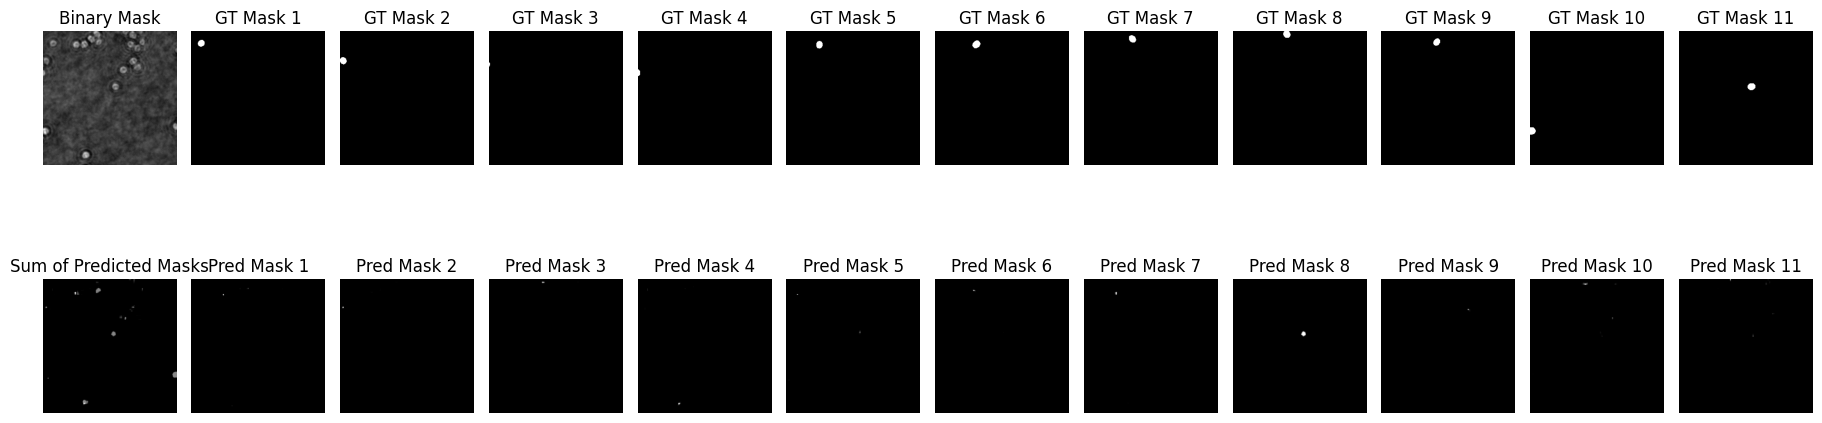

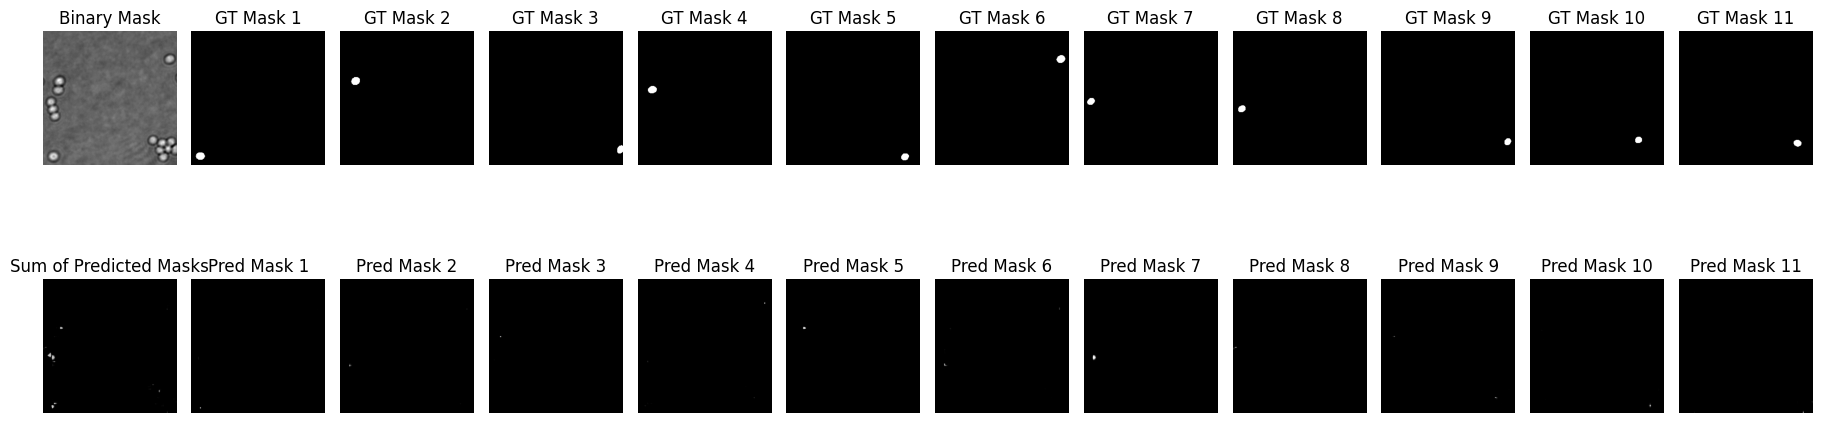

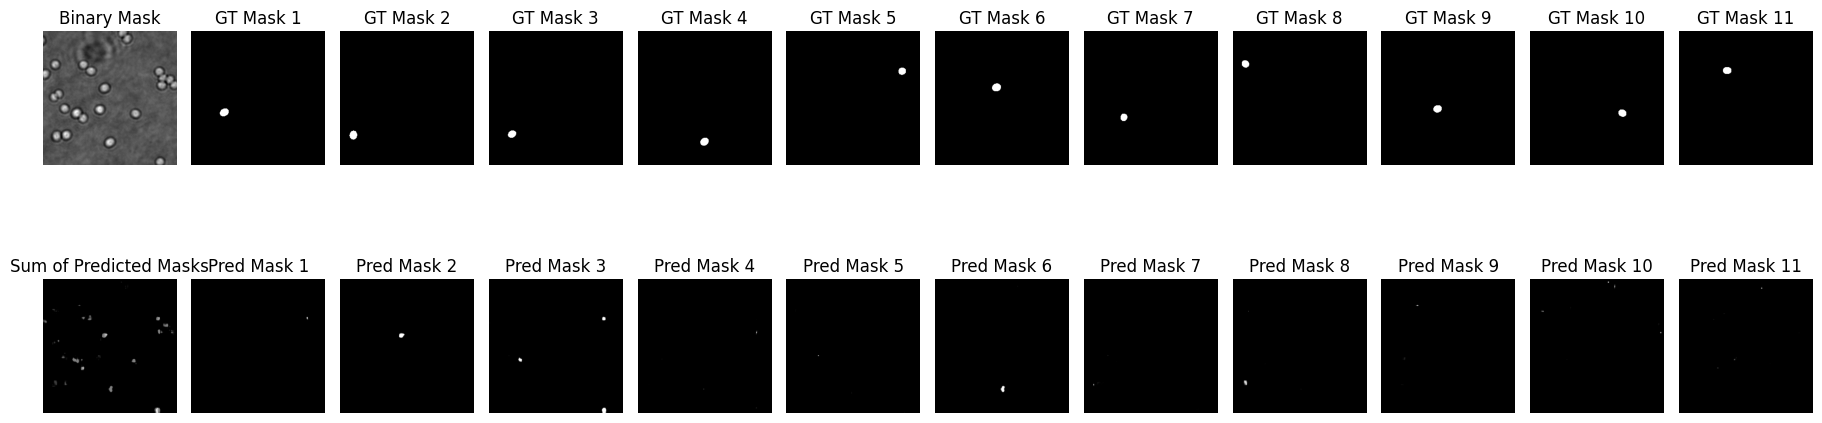

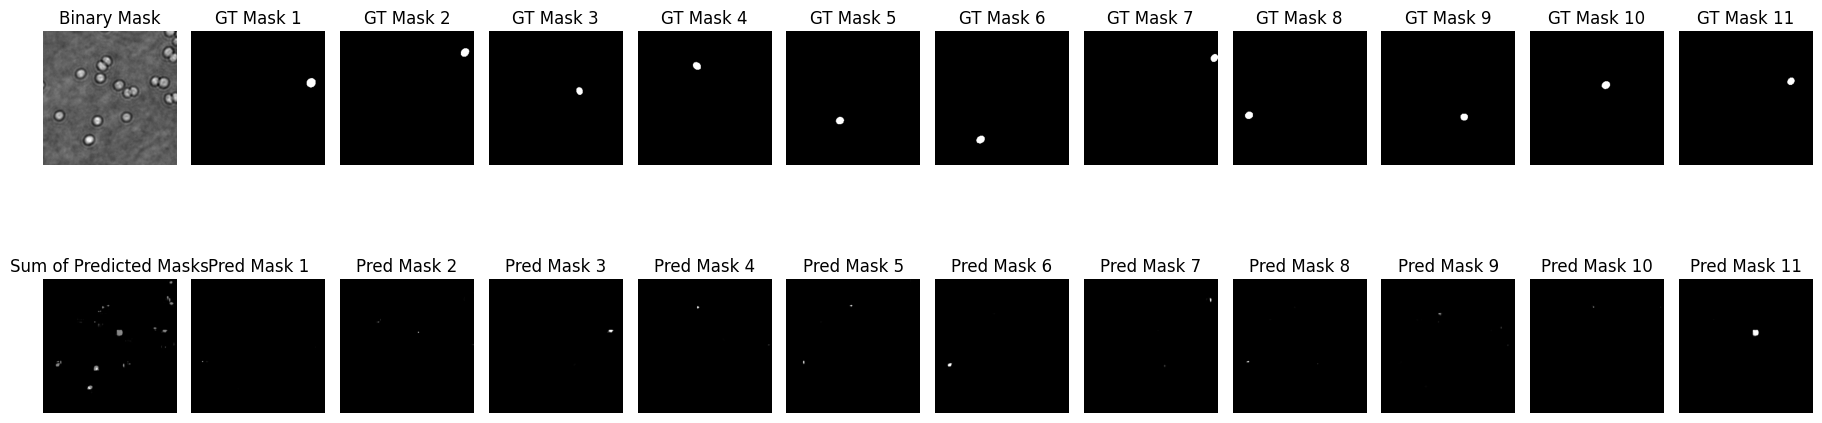

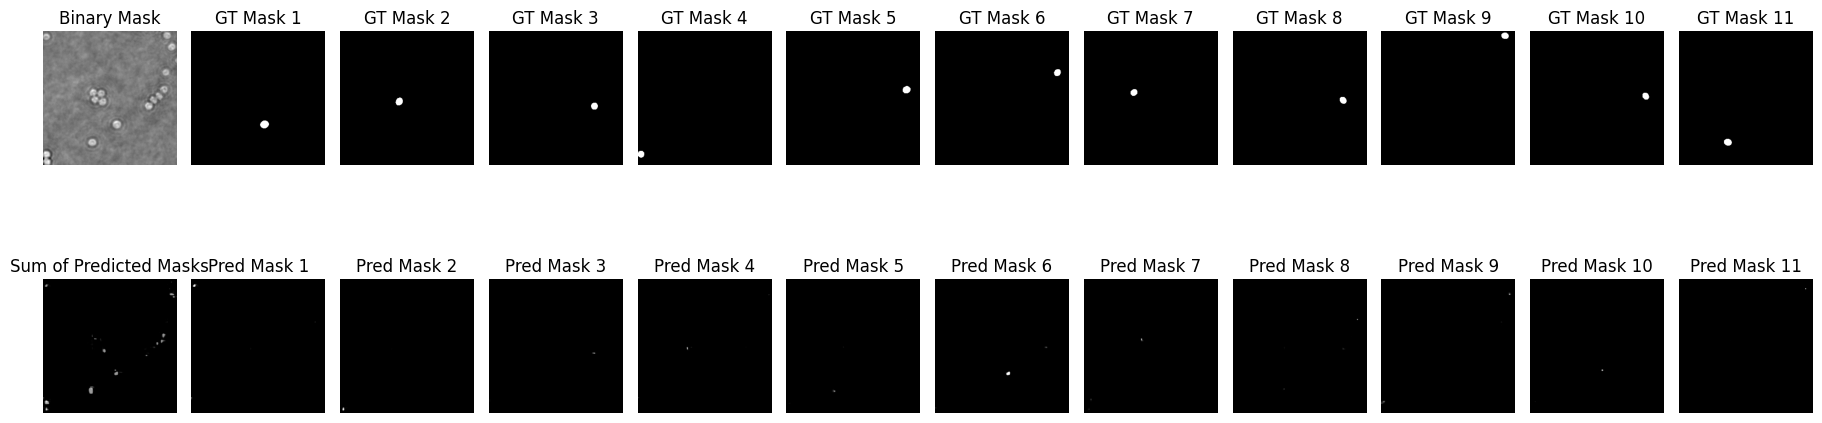

Total Loss: 0.0106


In [66]:
# Load Model 

model.load_state_dict(torch.load(f'cnn_transformer_model.pth'))
model.eval()

# Test 
with torch.no_grad():
    total_loss = 0
    for binary_mask, instance_masks in test_loader:
        binary_mask = binary_mask.to(device)  # Move binary_mask to device
        instance_masks = instance_masks.to(device) 

        outputs = model(binary_mask)

        base_loss = nn.BCELoss()
        custom_loss = CustomLoss(base_loss, alpha=2.0, beta=10.0)

        # Compute the loss
        loss = custom_loss(outputs, instance_masks)
        total_loss += loss.item()

        # Visualizing the binary mask
        binary_mask = binary_mask[0].squeeze(0).cpu().numpy()
        instance_masks = instance_masks[0].cpu().numpy()
        predicted_masks = outputs[0].cpu().numpy()

        fig, axes = plt.subplots(2, 11 + 1, figsize=(18, 6))

        # Binary Mask
        axes[0, 0].imshow(binary_mask, cmap='gray')
        axes[0, 0].set_title("Binary Mask")
        axes[0, 0].axis("off")

        # Ground Truth Masks
        for i in range(11):
            axes[0, i + 1].imshow(instance_masks[..., i], cmap='gray')
            axes[0, i + 1].set_title(f"GT Mask {i+1}")
            axes[0, i + 1].axis("off")

        # Predicted Masks
        for i in range(11):
            axes[1, i + 1].imshow(predicted_masks[..., i], cmap='gray')
            axes[1, i + 1].set_title(f"Pred Mask {i+1}")
            axes[1, i + 1].axis("off")

        # Sum of Predicted Masks
        predicted_sum = np.sum(predicted_masks, axis=-1)
        axes[1, 0].imshow(predicted_sum, cmap='gray')
        axes[1, 0].set_title("Sum of Predicted Masks")
        axes[1, 0].axis("off")

        # Layout adjustment
        plt.tight_layout()
        plt.show()
    
    print(f'Total Loss: {total_loss/len(test_loader):.4f}')
    
